See 19 in https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/04-One-Dimensional-Kalman-Filters.ipynb

Another useful ref https://stackoverflow.com/questions/33384112/kalman-filter-one-dimensional-several-approaches

In [1]:
from random import Random
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

In [2]:
random = Random()
random.gauss(mu=0, sigma=1)

-0.5021591819106531

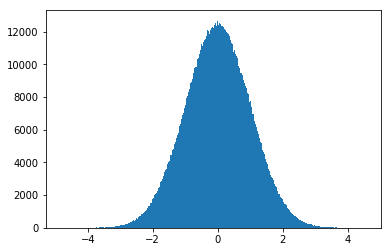

In [3]:
randoms = []
for i in range(1000000):
    randoms.append(random.normalvariate(mu=0, sigma=1))
plt.hist(randoms, bins=300);

The process variance (`process_var`) tells the filter how much the system is changing over time. If you set this number too low the filter will not be able to react to changes that are happening

In [4]:
def volt(voltage, std):
    return voltage + (random.gauss(mu=0, sigma=1) * std)

voltage_std = .13  # Need to configure/estimate ORIG
process_var = .05**2  # Need to configure/estimate ORIG
#process_var = .5**2  # Need to configure/estimate HIGH
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
time = [i for i in range(N)]
readings = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

In [5]:
for z in readings:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

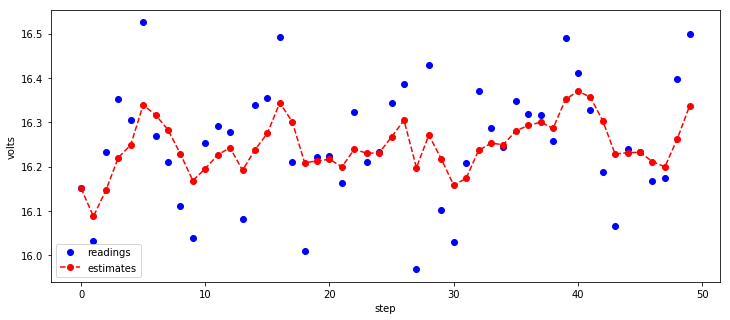

In [6]:
plt.figure(figsize=(12,5))
plt.plot(time, readings, 'bo', label='readings') # Dummy reading
plt.plot(time, estimates, 'ro--', label='estimates')
plt.legend()
#plt.ylim(16, 17)
plt.xlabel('step')
plt.ylabel('volts')
plt.show()
    
#plt.plot(ps)
#plt.title('Variance')
#print('Variance converges to {:.3f}'.format(ps[-1]))

Not bad, but note that our process model is a gaussian of mean zero. If there were drift, we would need to include this in the process model.

## Now add in a drift
Experiment with the process variance `process_var`, vary between 0 - 1

In [7]:
def volt(drift, voltage, std):
    return drift + voltage + (random.gauss(mu=0, sigma=1) * std)

voltage_std = .7  # Need to configure/estimate ORIG
process_var = .5**2  # Need to configure/estimate ORIG
#process_var = .5**2  # Need to configure/estimate HIGH
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
time = [i for i in range(N)]
readings = [volt(i/3, actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

In [8]:
for z in readings:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

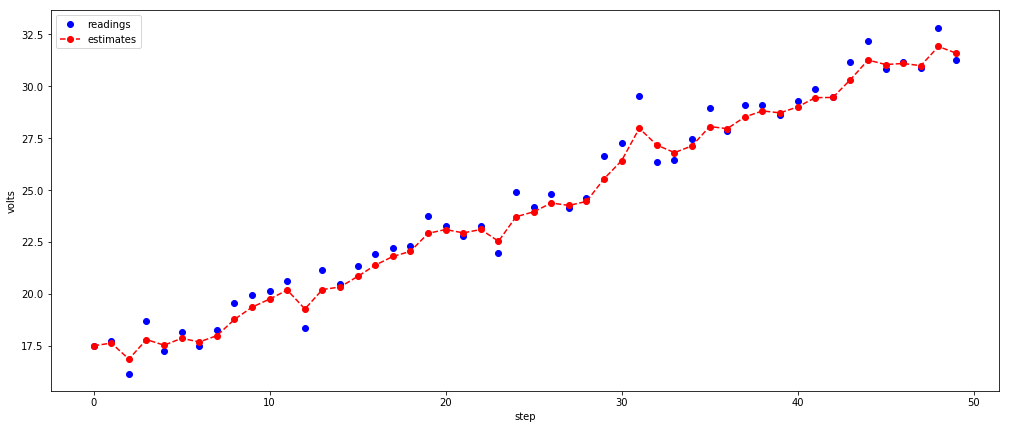

In [9]:
plt.figure(figsize=(17,7))
plt.plot(time, readings, 'bo', label='readings') # Dummy reading
plt.plot(time, estimates, 'ro--', label='estimates')
plt.legend()
#plt.ylim(16, 17)
plt.xlabel('step')
plt.ylabel('volts')
plt.show()

This doesn't look too bad

## Kalman 1D class
Lets create a simple class that we could use in Home-Assistant

In [10]:
"""
Class for a 1D Kalman filter. The user will have to configure the filter sensitivity (range 0-1),
and the measurement standard deviation - if the process is stationary this is easy to calculate using 
one of the stats sensors.
"""

class kalman:
    """Class for a 1D Kalman filter."""
    
    def __init__(self, sensitivity, measurement_std):
        """Initialise the class"""
        self._process_var = sensitivity**2  # sensitivity should be in range 0-1
        self._measurement_var = measurement_std**2
        self._x = None # initial state, will init on first reading
        self._process_model = gaussian(0., self._process_var)
        self._prior = None
    
    def process_measurement(self, measurement):
        """Process a measurement"""
        if self._x is None:
            self._x = gaussian(measurement, 1000.) # initial state
            print("Processing first measurement")
        else:
            self._prior = predict(self._x, self._process_model)
            self._x = update(self._prior, gaussian(measurement, self._measurement_var))
        
    @property
    def state(self):
        """Return the state of the entity."""
        return self._x.mean

In [11]:
sensitivity = 0.7 # range 0 - 1
measurement_std = voltage_std # Estimate or calculate

kalman_1 = kalman(sensitivity, measurement_std)

states = []
for z in readings:
    kalman_1.process_measurement(z)
    # save for latter plotting
    states.append(kalman_1.state)

Processing first measurement


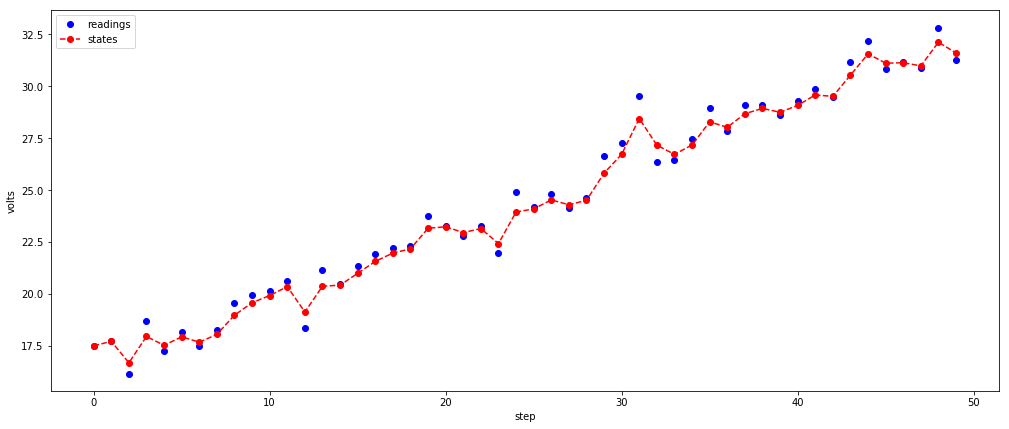

In [12]:
plt.figure(figsize=(17,7))
plt.plot(time, readings, 'bo', label='readings') # Dummy reading
plt.plot(time, states, 'ro--', label='states')
plt.legend()
#plt.ylim(16, 17)
plt.xlabel('step')
plt.ylabel('volts')
plt.show()